In [1]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

# Generation of synthetic data

In [2]:
df = pd.read_csv('signal.txt',header=None)
x = np.asarray(df)

Create T using the exponential sampling strategy : $$(\forall n \in\{1, \ldots, N\}) \quad T^{(n)}=T_{\min } \exp \left(-(n-1) \frac{\log \left(T_{\min } / T_{\max }\right)}{N-1}\right)$$
And create t using the regular sampling strategy : $$(\forall m \in\{1, \ldots, M\}) \quad t^{(m)}=t_{\min }+\frac{m-1}{M-1}\left(t_{\max }-t_{\min }\right)$$
Then, K is created using : $$(\forall m \in\{1, \ldots, M\})(\forall n \in\{1, \ldots, N\}) \quad K^{(m, n)}=\exp \left(-T^{(n)} t^{(m)}\right)$$

$\bar x$

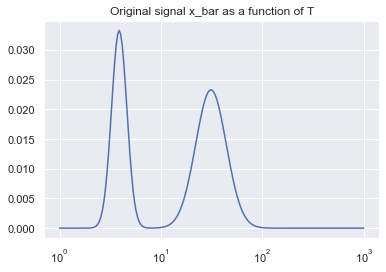

In [186]:
def exp_T(n, Tmin, Tmax, N):
    """
    Exponential sampling strategy
    """
    return Tmin * np.exp(- (n - 1) * np.log( Tmin / Tmax ) / (N - 1)) 

def reg_T(m, tmin, tmax, M):
    """
    Regular sampling strategy
    """
    return tmin + (tmax - tmin) * (m-1)/ (M - 1) 

N = 200
n = np.arange(N)+1
T_n_exp = exp_T(n, 1, 1000, N)

fg, ax  = plt.subplots(1,1)
ax.set_xscale('log')
ax.plot(T_n_exp, x)
ax.set_title('Original signal x_bar as a function of T')

M = 50
m = np.arange(M)+1
T_n_reg = reg_T(m, 0, 1.5, M)

K = np.exp(-T_n_reg.reshape(-1,1) @ T_n_exp.reshape(-1,1).T)

Text(0.5, 1.0, 'Resulting noisy data y as a function of t')

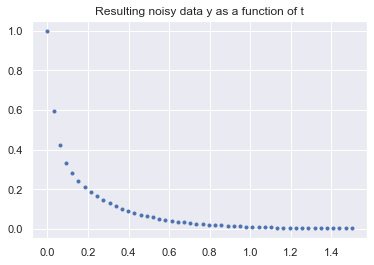

In [185]:
z = K @ x
#sigma_2 = (1e-4 * z  * z.T * np.eye(M))
sigma_2 = np.square(1e-2 * z[0]) * np.eye(M)
w = np.random.normal(loc = 0, scale=np.diag(sigma_2))
y = z.reshape(-1,) + w

fg, ax  = plt.subplots(1,1)
ax.plot(T_n_reg, y, linestyle='',marker='.')
ax.set_title('Resulting noisy data y as a function of t')

# Comparison of regularization strategies

## Smoothness prior 
$$\left(\forall x \in \mathbb{R}^{N}\right) \quad g(x)=\frac{1}{2}\|D x\|^{2}$$

### Question 1 : Existence and uniqueness of the solution to the problem
Let's  $$ f(x) = \frac{1}{2} \vert \vert Kx - y \vert\vert ^ 2 + \beta \vert\vert D x \vert\vert^2 $$ 
We have the following hessian matrix for $f$ : 
$$ \nabla ^2 f = K^TK + \beta D^TD $$
which is a positive definite matrix and therefore f is **stricly convex**. f is also clearly **continuous** and **coercive**. 

Thus there exists a unique solution to the problem of minimizing f. This means that $\operatorname{Argmin}(f) \neq \varnothing$.

### Question 2 : Approach to solve problem 
We can compute the gradient of $f$ and have a closed-form expression for its zero. 
$$ \nabla f (x) = K^T K x - K^T y + \beta D^T D x $$
$$ \nabla f (x) = 0 \Leftrightarrow x = (K^T K + \beta D^T D)^{-1} K^T y $$ 
From question 1, we are sure that the zero of the gradient is the solution to the minization problem

In [6]:
D = np.eye(N)
for index in range(N):
    D[index,index-1] = -1

Text(0.5, 1.0, 'Reconstruction result, Smoothness prior, \nbeta=0.08, normalized_error=16.166')

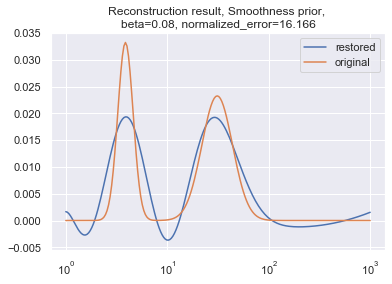

In [188]:
def smoothness_prior(beta):
    return np.linalg.inv(K.T @ K + beta*(D.T @ D)) @ K.T @ y

betas = [8e-2]#[10**(-k/4) for k in range(1,32)]
best_error = np.inf
for beta in betas:
    x_rec = smoothness_prior(beta)
    std_error = np.linalg.norm(x-x_rec)/np.linalg.norm(x)
    if std_error < best_error:
        best_error = std_error
        best_beta = beta
        best_x_rec = x_rec
    
fg, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.plot(T_n_exp, best_x_rec, label='restored')
ax.plot(T_n_exp, x, label='original')
ax.legend()
ax.set_title('Reconstruction result, Smoothness prior, \nbeta={0}, normalized_error={1:.3f}'.format(best_beta, 
                                                                                              best_error))

> Using this technique the best normalized quadratic error between the signal and its reconstruction is : $E(\widehat{x}, \bar{x})=\frac{\|\widehat{x}-\bar{x}\|^{2}}{\|\bar{x}\|^{2}} = 16.166$

---

## Smoothness prior + constraints
$$\left(\forall x \in \mathbb{R}^{N}\right) \quad g(x)=\frac{1}{2}\|D x\|^{2}+\iota_{\left[x_{\min }, x_{\max }\right]^{N}}(x)$$

### Question 1 
First, we are working in $\mathbb{R}^{N}$ which is of finite dimension.
The addition of constraints here does not impact the strict convexity nor the coercivity of the function to minimize. The l.s.c property of the function is still held because the domain of the function is reduced which doesn't impact the l.s.c property. Thus, the function is still inf-compact and $\left[x_{\min }, x_{\max }\right]^{N}$ being convex, there still exists a unique minimizer to the optimization problem when the constraint is added.

Thus there exists a unique solution to the problem of minimizing $ f+\beta \iota_{ [ x_{min}, x_{max}]^{N} } $. This means that $\operatorname{Argmin}(f+\beta \iota_{ [ x_{min}, x_{max}]^{N} } ) \neq \varnothing$.

### Question 2 

The previous approach is not suitable with the addition of the $\iota_{ [ x_{min}, x_{max}] }$ term. 
We will use the forward-backward algorithm which, in our case, ends up being the projected gradient version on $[ x_{min}, x_{max}]^{N}$ a nonempty closed convex subset of $\mathbb{R}^{N}$.

We consider the minimization of $ f+\beta \iota_{ [ x_{min}, x_{max}]^{N} } $ with $$ f(x) = \frac{1}{2} \vert \vert Kx - y \vert\vert ^ 2 + \beta \vert\vert D x \vert\vert^2 $$ 

As seen previously, we have : 
$$ \nabla f (x) = K^T K x - K^T y + \beta D^T D x $$ 

Therefore $f$ has a Lipschitz gradient with a Lipschitz constant  $max(specter(K^T K + \beta D^TD)$  
As the other hypothesis are verified, the algortihm converges to a minimizer of $f$ in $[x_{min}, x_{max}]^{N}$ 

It took 10 iterations to converge.


Text(0.5, 1.0, 'Reconstruction result, Projected Gradient, \nbeta=0.01, normalized_error=15.785')

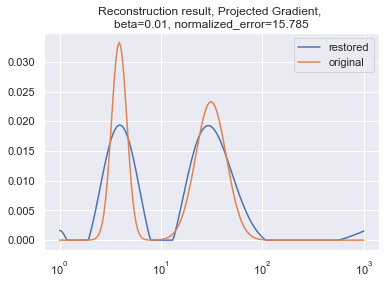

In [225]:
# choose beta
beta = 1e-2
nu = np.max(abs(np.linalg.eigvals(K.T @ K + beta * D.T @ D)))
# choose gamma in ]0, 2/nu[
gamma = 1/nu
delta = 2 - gamma*nu/2
# choose lbda in [0, delta[
lbda = delta/2#

assert gamma > 0 and gamma < 2/nu
assert lbda >=0 and lbda < delta

def proj_grad(gamma, lbda, beta, max_iter=1000):
    itr = 0
    x_min = np.min(x)
    x_max = np.max(x)
    x_n = best_x_rec #np.random.rand(x.shape[0],x.shape[1])
    convergence = False
    while itr < max_iter and not convergence:
        w_n = x_n - gamma * beta * D.T @ D @ x_n
        x_n1 = x_n + lbda * (np.clip(w_n, a_min=x_min, a_max=x_max) - x_n)
        error = np.linalg.norm(x_n1-x_n)/np.linalg.norm(x_n)
        convergence = error <= 1e-6
        x_n = x_n1
        itr+=1
    
    print('It took {} iterations to converge.'.format(itr))
        
    return x_n, error

x_rec, error = proj_grad(gamma, lbda, beta, max_iter=1000)
rec_error = np.linalg.norm(x-x_rec)/np.linalg.norm(x)
fg, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.plot(T_n_exp, x_rec, label='restored')
ax.plot(T_n_exp, x, label='original')
ax.legend()
ax.set_title('Reconstruction result, Projected Gradient, \nbeta={0}, normalized_error={1:.3f}'.format(beta, 
                                                                                                      rec_error))

> Using this technique the best normalized quadratic error between the signal and its reconstruction is : $E(\widehat{x}, \bar{x})=\frac{\|\widehat{x}-\bar{x}\|^{2}}{\|\bar{x}\|^{2}} = 15.785$

---

### Sparsity prior : proximal point algorithm
$$\left(\forall x \in \mathbb{R}^{N}\right) \quad g(x)=\|x\|_{1}$$

### Question 1 

Let's note $\left(\forall x \in \mathbb{R}^{N}\right) f(x) = \frac{1}{2} \vert \vert Kx - y \vert\vert ^ 2 $ and $ g(x) = \vert\vert x \vert\vert_1 $, then we want to minimize $f+\beta g$.
As seen before, f is continuous, strictly convex and coercive. g being a norm is also continuous, strictly convex and coercive. Thus, $f+\beta g$ also has those properties and thereby the optimization problem admits a unique solution. This means that $\operatorname{Argmin}(f+\beta g) \neq \varnothing$.

### Question 2 


We consider the minimization of $ f+\beta g $ with $$ f(x) = \frac{1}{2} \vert \vert Kx - y \vert\vert ^ 2 $$ 
and 
$$ g(x) = \vert\vert x \vert\vert_1  $$  
The issue here is that f is differentiable but g is not. Hence, we will use the forward-backward algorithm. 

As seen previously, we have : $f \in \Gamma_0(\mathbb{R}^n)$, $f$ has a Lipschitz gradient with a Lipschitz constant  $max(specter(K^T K))$ and $g \in \Gamma_0(\mathbb{R}^n)$.
As the other hypothesis are verified, the algortihm converges to a minimizer of $f+\beta g$. 
We also have $\operatorname{prox}_{\beta g} = $


It took 31 iterations to converge.


Text(0.5, 1.0, 'Reconstruction result, Sparsity prior, beta=0.01, normalized_error=0.998')

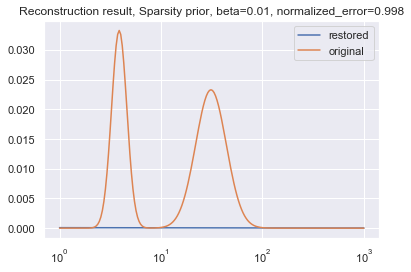

In [227]:
def prox_g(u, beta, chi):
    ''' 
    return the prox_{𝛽 * ||.||_1}(x)
    '''
    return np.sign(u)*np.maximum(beta*np.abs(u) - chi, 0)

def for_back(gamma, lbda, beta, chi=1e-8, eps=1e-6, max_iter=1000):
    itr = 0
    x_n = best_x_rec.reshape(-1,1)
    convergence = False 
    while not convergence and itr < max_iter: 
        y_n = x_n - gamma * K.T @ (K @ x_n - y.reshape(-1,1))

        x_n1 = x_n + lbda * (prox_g(y_n, beta, chi) - x_n)
        if np.isinf(x_n1).any():
            raise ValueError
        error = np.linalg.norm(x_n1 - x_n) / np.linalg.norm(x_n)
        convergence = error < eps
        x_n = x_n1
        itr += 1
        
    print('It took {} iterations to converge.'.format(itr))
        
    return x_n, error

beta = 1e-2
lambda_ = 1/2
nu = np.max(abs(np.linalg.eigvals(K.T @ K)))
gamma = 1/ nu 
    
x_rec, error = for_back(gamma, lbda, beta, chi=1e-6, eps=1e-15, max_iter=1000)
rec_error = np.linalg.norm(x-x_rec)/np.linalg.norm(x)
fg, ax = plt.subplots(1,1)
ax.set_xscale('log')
ax.plot(T_n_exp, x_n, label='restored')
ax.plot(T_n_exp, x, label='original')
ax.legend()
ax.set_title('Reconstruction result, Sparsity prior, beta={0}, normalized_error={1:.3f}'.format(beta, rec_error))